# 참고 사이트
https://www.kaggle.com/code/justicevil/covid19-image-classification-vgg16-val-acc-98

#1. Import

In [3]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

#2. 데이터 분리

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil

# 이미지 크기 및 배치 사이즈 설정
height, width = 224, 224
batch_size = 64

# 데이터 경로 설정
DATA_DIR = '/content/drive/MyDrive/DeepL_Class_ws/img_classification_01/archive'
POS_DIR = os.path.join(DATA_DIR, 'CT_COVID')
NEG_DIR = os.path.join(DATA_DIR, 'CT_NonCOVID')

# 양성과 음성 파일 목록 가져오기
pos_files = [os.path.join(POS_DIR, f) for f in os.listdir(POS_DIR)]
neg_files = [os.path.join(NEG_DIR, f) for f in os.listdir(NEG_DIR)]

# 전체 이미지 경로와 레이블 생성
images = pos_files + neg_files
labels = np.array([1] * len(pos_files) + [0] * len(neg_files))

# 데이터셋 분할 (80% train+val, 20% test)
images_train_val, images_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, random_state=123, stratify=labels)

# Train+Val 데이터를 다시 80% train, 20% validation으로 분할
images_train, images_val, y_train, y_val = train_test_split(images_train_val, y_train_val, test_size=0.2, random_state=123, stratify=y_train_val)

# 임시 디렉토리 생성
base_dir = '/content/temp_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# 각 클래스의 하위 폴더 생성
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(folder, 'CT_COVID'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'CT_NonCOVID'), exist_ok=True)

# 이미지 복사 함수 정의
def copy_files(image_list, label_list, target_dir):
    for img_path, label in zip(image_list, label_list):
        if label == 1:
            target_class = 'CT_COVID'
        else:
            target_class = 'CT_NonCOVID'

        shutil.copy(img_path, os.path.join(target_dir, target_class))

# 이미지 복사
copy_files(images_train, y_train, train_dir)
copy_files(images_val, y_val, val_dir)
copy_files(images_test, y_test, test_dir)


# ImageDataGenerator를 사용하여 학습, 검증, 테스트 데이터 세트를 생성합니다.
# 훈련, 검증, 테스트 데이터 생성기 호출
train_generator = ImageDataGenerator(rescale=1./255.).flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    color_mode='grayscale',  # 흑백 이미지를 로드할 때 사용
    class_mode='binary'
)

validation_generator = ImageDataGenerator(rescale=1./255.).flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    color_mode='grayscale',  # 흑백 이미지를 로드할 때 사용
    class_mode='binary'
)

test_generator = ImageDataGenerator(rescale=1./255.).flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    color_mode='grayscale',  # 흑백 이미지를 로드할 때 사용
    class_mode='binary'
)

# 데이터 통계 출력
total_train_labels = train_generator.labels
total_val_labels = validation_generator.labels
total_test_labels = test_generator.labels

print('\n\nTraining Set:', {
    'Negative Cases': len(np.where(total_train_labels == 0)[0]),
    'Positive Cases': len(np.where(total_train_labels == 1)[0])
})

print('\n\nValidation Set:', {
    'Negative Cases': len(np.where(total_val_labels == 0)[0]),
    'Positive Cases': len(np.where(total_val_labels == 1)[0])
})

print('\n\nTest Set:', {
    'Negative Cases': len(np.where(total_test_labels == 0)[0]),
    'Positive Cases': len(np.where(total_test_labels == 1)[0])
})


Found 476 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


Training Set: {'Negative Cases': 223, 'Positive Cases': 253}


Validation Set: {'Negative Cases': 56, 'Positive Cases': 64}


Test Set: {'Negative Cases': 70, 'Positive Cases': 80}


In [29]:
from PIL import Image
#원본이미지 shape확인

# 이미지 경로 설정 (원하는 이미지 파일로 경로를 변경하세요)
image_path = '/content/drive/MyDrive/DeepL_Class_ws/img_classification_01/archive/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png'

# 이미지 열기
img = Image.open(image_path)

# 이미지의 크기 확인
print(f"Image size: {img.size}")  # (width, height)
print(f"Image mode (channels): {img.mode}")  # 'L' for grayscale, 'RGB' for color

Image size: (580, 335)
Image mode (channels): RGBA


In [25]:
# 데이터 생성기에서 배치를 가져와 확인해보기
batch = next(train_generator)
print(f"Batch shape: {batch[0].shape}")  # 이미지의 배치 모양 확인
print(f"Labels shape: {batch[1].shape}")  # 레이블의 배치 모양 확인

Batch shape: (64, 224, 224, 3)
Labels shape: (64,)


#3. 이미지 확인

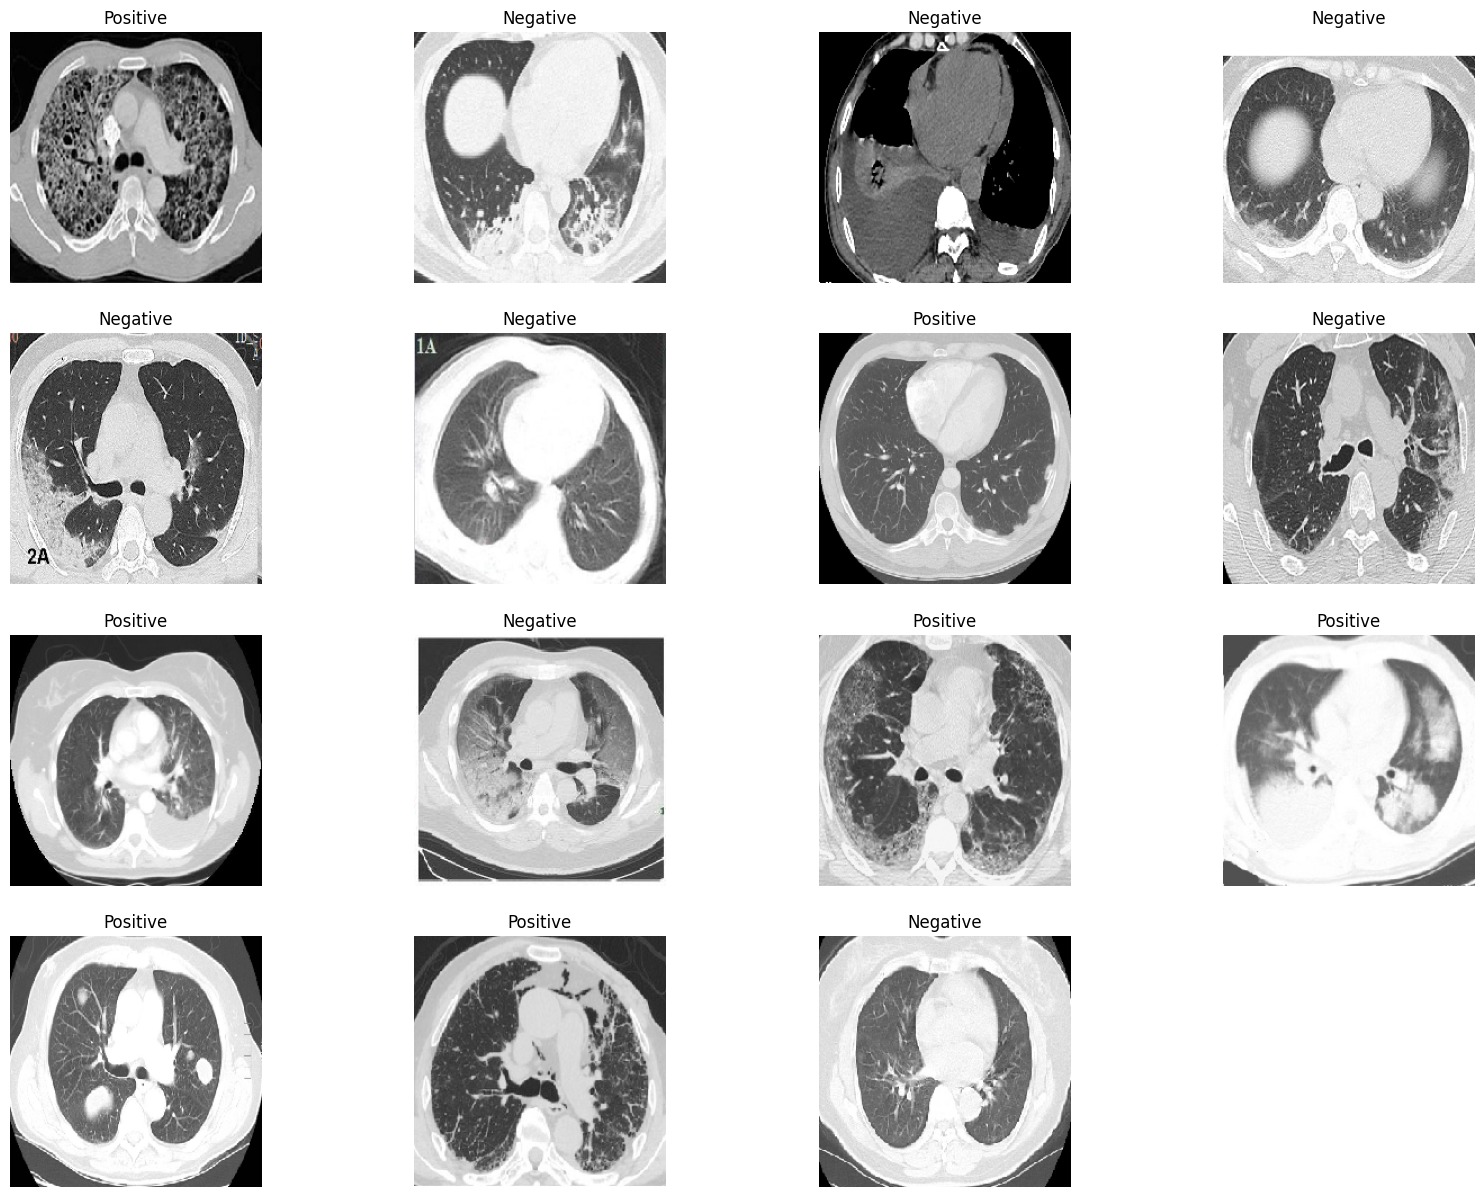

In [14]:
# 이미지 시각화 함수 정의
def image_plot(generator, image_numbers):
    # 배치에서 이미지와 레이블을 가져옴
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers / 4), 4, i + 1)
        plt.imshow(img_feature[i])
        # 레이블에 따라 제목을 지정 (0: Negative, 1: Positive)
        plt.title("Negative" if img_label[i] == 0 else "Positive")
        plt.axis("off")
    plt.show()

# 훈련 세트에서 15개 이미지 시각화
image_plot(train_generator, 15)

#4. 모델 구현 (VGG16)

In [27]:
tf.keras.backend.clear_session()

# VGG16 모델에 사용할 입력 크기
input_shape = (height, width, 1)  # 흑백 이미지를 입력으로 받음

# VGG16 모델 불러오기 (사전 학습된 가중치 사용, 최상위 분류 층 제외)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)  # VGG16이 요구하는 입력 크기
)
base_model.trainable = False  # VGG16 모델의 가중치 동결

# 새로운 모델 구성
model_vgg16 = tf.keras.Sequential()
model_vgg16.add(tf.keras.layers.Conv2D(3, (3, 3), padding='same', input_shape=input_shape))  # 1채널을 3채널로 변환
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.Flatten())  # Flatten 사용하여 출력 변환

# 추가된 밀집 층 (Dense Layers)
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))  # 과적합 방지를 위한 드롭아웃
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))  # 과적합 방지를 위한 드롭아웃

# 최종 이진 분류 층 (양성, 음성)
model_vgg16.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# 모델 컴파일 (이진 분류에 적합한 손실 함수 및 평가 지표 사용)
model_vgg16.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc'])

# 모델 요약
model_vgg16.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 3)         │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,203,551 (80.89 MB)

 Trainable params: 6,488,863 (24.75 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#5. 모델 학습 및 평가

In [31]:
# 모델 저장 디렉토리 생성
os.makedirs('model', exist_ok=True)

# 콜백 함수 정의
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model/vgg16_best.keras',
    monitor='val_acc',  # 검증 정확도를 모니터링
    verbose=1,
    mode='max',
    save_best_only=True
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    restore_best_weights=True,
    patience=5
)

callbacks_list = [checkpoint, early_stopping]

# 모델 학습
history = model_vgg16.fit(
    train_generator,
    validation_data=validation_generator,  # 검증 데이터를 validation_generator로 사용
    epochs=50,
    shuffle=False,
    verbose=True,
    callbacks=callbacks_list
)

# 모델 평가
test_loss, test_acc = model_vgg16.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.5631 - loss: 1.2403   
Epoch 1: val_acc improved from -inf to 0.57500, saving model to model/vgg16_best.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 119s 10s/step - acc: 0.5620 - loss: 1.2634 - val_acc: 0.5750 - val_loss: 0.7114
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - acc: 0.5538 - loss: 1.2255
Epoch 2: val_acc improved from 0.57500 to 0.69167, saving model to model/vgg16_best.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 850ms/step - acc: 0.5569 - loss: 1.2090 - val_acc: 0.6917 - val_loss: 0.5845
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - acc: 0.6050 - loss: 0.7611
Epoch 3: val_acc improved from 0.69167 to 0.70000, saving model to model/vgg16_best.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 852ms/step - acc: 0.6060 - loss: 0.7558 - val_acc: 0.7000 - val_loss: 0.5653
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - acc: 0.6285 - loss: 0.6068
Epoch 4: val_acc improved from 0.70000 to 0.73333, saving model to model/vgg16_best.keras
8/8 ━━━━━━━━━━━━━━━━━━